<div align="right">Naoaki ONO, Shigehiko KANAYA <br/>
NAIST DSC</div>

[Open in Google Colaboratory](https://colab.research.google.com/github/naono-git/colaboratory/blob/master/note_04_hello_CNN.ipynb)

# はじめてのGAN

深層学習の強力な学習方法として汎用性の高い「敵対的生成ネットワーク(Generative Adiversarial networks: GAN)」による学習を行なってみましょう。

GANはその汎用性の高さから、急速に普及するにつれいろいろなバリエーションへと発展していますがここではオリジナルのモデル
[(Ian Goodfellow 2014)](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)になるべく近い形で実装してみましょう。

まずは例によって必要なライブラリを適当にインポートして準備です。

In [1]:
import argparse
import os
import sys
import code
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import cv2

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import LeakyReLU

from keras.optimizers import Adam

from keras import backend as K



Using TensorFlow backend.


## MNIST

深層学習の入門用としてすっかり定番となった<a href="https://en.wikipedia.org/wiki/MNIST_database">MNIST</a>データセットを使って、GANによる手書き文字の画像認識を学習してみましょう。
<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"></img>

In [2]:
(x_train_org, y_train_org), (x_test_org, y_test_org) = mnist.load_data()

nc = 10         # classify hand-written 10 digits [0-9]
nx, ny = 28, 28 # image size

11493376/11490434 [==============================] - 0s 0us/step


### データ整形

学習を簡単にするため、画像のピクセル値を[0,1]の実数に、教師データとなるの0~9までの数字の分類を、対応する数字のところだけが1、あとは0として表される10次元のベクトル（one-hotベクトルと呼ばれます）に変換します。
$$
\begin{eqnarray*}
0 &\Rightarrow& (1,0,0, \dots, 0)\\
1 &\Rightarrow& (0,1,0, \dots, 0)\\
&\vdots& \\
9 &\Rightarrow& (0,0,0, \dots, 1)\\
\end{eqnarray*}
$$

In [0]:
x_trn = x_train_org.astype('float32').reshape(x_train_org.shape[0], ny, nx, 1)/255
x_tst = x_test_org.astype('float32').reshape(x_test_org.shape[0], ny, nx, 1)/255

In [0]:
y_trn = keras.utils.to_categorical(y_train_org, nc)
y_tst = keras.utils.to_categorical(y_test_org, nc)

ネットワークを構築します。

レイヤーオブジェクトとして2次元畳み込みを行う`Conv2D`を使っている以外はあまり変わっていません。

特徴マップを計算するために二回畳み込みを行なっています。

（注）そのまま畳み込みを行うと、特徴マップが増えるたびに出力データの数が増えていってしまい、分類を計算するのが難しくなります。ここではマップを計算する位置を一つ飛ばしにすることでデータを間引いています。マップを計算した後でサイズを縮小する「プーリング」という方法を使う場合もあります。

最終的な特徴マップから32ノードの全結合ネットワークを経て10ノードの出力が得られるようになっています。

10ノードのうち値が一番大きいものが予測された文字になります。

In [5]:
sess = K.get_session()

leaky_relu = LeakyReLU(alpha=0.1)

n_x = n_y = 28
n_z = 10

l_inpu_x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='l_inpu_x')
l_inpu_y = tf.placeholder(tf.float32, shape=[None, 1], name='l_inpu_y')
l_inpu_z = tf.placeholder(tf.float32, shape=[None, n_z], name='l_inpu_z')

l_d_conv1 = Conv2D(8, kernel_size=(5, 5), strides=(2, 2), activation='relu', padding="same", name='d_conv1')(l_inpu_x)
l_d_conv2 = Conv2D(16, kernel_size=(5, 5), strides=(2, 2), activation='relu', padding="same", name='d_conv2')(l_d_conv1)
l_d_flat1 = Flatten(name='d_flat1') (l_d_conv2)
l_d_dens1 = Dense(32, activation='relu', name='d_dens1')(l_d_flat1)
l_d_out_1 = Dense(1, activation='sigmoid', name='d_out_1')(l_d_dens1)
loss_d = keras.losses.binary_crossentropy(l_inpu_y, l_d_out_1)
opti_d = tf.train.AdagradOptimizer(learning_rate=0.001)
trai_d = opti_d.minimize(loss_d)

l_g_dens1 = Dense(64, activation='relu', name='gn_dense1')(l_inpu_z)
l_g_dens2 = Dense(7*7*128, activation='relu', name='gn_dense2')(l_g_dens1)
l_g_resh1 = Reshape((7,7,128), name="gn_reshape")(l_g_dens2)
l_g_conv1 = Conv2D(64, kernel_size=(5, 5), padding="same", activation='relu', name='gn_conv3')(l_g_resh1)
l_g_upsa1 = UpSampling2D(name="gn_upsampling1")(l_g_conv1)
l_g_conv2 = Conv2D(1, kernel_size=(5, 5), padding="same", activation='sigmoid',  name='gn_conv4')(l_g_upsa1)
l_g_out_2 = UpSampling2D(name="gn_upsampling2")(l_g_conv2)

loss_g = keras.losses.binary_crossentropy(l_inpu_y, 1-l_d_out_1)
opti_g = tf.train.AdagradOptimizer(learning_rate=0.001)
trai_g = opti_g.minimize(loss_g)

sess.run(tf.global_variables_initializer())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
n_batch = 3000
z_tmp = np.reshape(np.random.normal(0, 1, n_batch*n_z),(n_batch,n_z))
x_fake = sess.run(l_g_out_2, feed_dict={l_inpu_z: z_tmp})

In [0]:
x_tmp = np.concatenate((x_trn[0:n_batch], x_fake),axis=0)
y_tmp = np.reshape(np.concatenate((np.repeat(1, n_batch),np.repeat(0, n_batch))), (n_batch*2,1))

In [42]:
y_tmp.shape

(6000, 1)

In [43]:
sess.run(trai_d, feed_dict={l_inpu_x: x_tmp, l_inpu_y: y_tmp})
hoge = sess.run(loss_d, feed_dict={l_inpu_x: x_tmp, l_inpu_y: y_tmp})
np.mean(hoge)

0.6705972

In [44]:
sess.run(trai_g, feed_dict={l_inpu_x: x_tmp, l_inpu_y: y_tmp, l_inpu_z: z_tmp})
fuga = sess.run(loss_g, feed_dict={l_inpu_x: x_tmp, l_inpu_y: y_tmp})
np.mean(fuga)

0.71360904

In [0]:
n_trn = x_trn.shape[0]
iii_bin = np.arange(n_batch, n_trn, n_batch)
iii_nn = np.arange(n_trn)
np.random.shuffle(iii_nn)
iii_batch = np.split(iii_nn,iii_bin)



In [0]:
m_batch = len(iii_batch)
iii = iii_batch[0]

In [47]:
m_batch


20

In [49]:
n_epoch = 10

loss_d_b = np.zeros(m_batch)

loss_d_n = np.zeros(n_epoch)

for tt in range(n_epoch):
  for ii in range(m_batch):
    iii = iii_batch[ii]
    z_tmp[:] = np.reshape(np.random.normal(0, 1, n_batch*n_z),(n_batch, n_z))
    x_fake = sess.run(l_g_out_2, feed_dict={l_inpu_z: z_tmp})
    x_tmp[0:n_batch] = x_trn[iii]
    sess.run(trai_d, feed_dict={l_inpu_x: x_tmp, l_inpu_y: y_tmp})

    loss_d_b[ii] = np.mean(sess.run(loss_d, feed_dict={l_inpu_x: x_tmp, l_inpu_y: y_tmp, l_inpu_z: z_tmp}))
  loss_d_t = np.mean(loss_d_b)
  print("discriminator: " ,  loss_d_t)
  loss_d_n[tt] = loss_d_t

print(loss_d_n[n_epoch-1])

discriminator:  0.6365043342113494
discriminator:  0.5125781714916229
discriminator:  0.33682180047035215
discriminator:  0.19778584763407708
discriminator:  0.11538832150399685
discriminator:  0.07067501805722713
discriminator:  0.04613631572574377
discriminator:  0.03204273907467723
discriminator:  0.023746038042008876
discriminator:  0.018309237994253637
0.018309237994253637


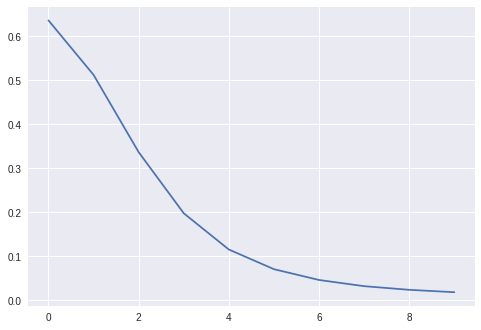

In [51]:
plt.plot(loss_d_n)

generator:  1.8242692828178406
generator:  1.0402538537979127
generator:  0.751443749666214
generator:  0.5783248215913772
generator:  0.4506625756621361
generator:  0.3471215009689331
generator:  0.2640050254762173
generator:  0.20190635174512864
generator:  0.15623241811990737
generator:  0.12347629815340042


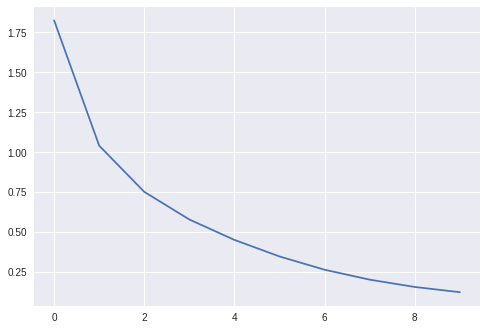

In [52]:
n_epoch = 10

loss_g_b = np.zeros(m_batch)

loss_g_n = np.zeros(n_epoch)

for tt in range(n_epoch):
  for ii in range(m_batch):
    iii = iii_batch[ii]
    z_tmp = np.reshape(np.random.normal(0, 1, n_batch*n_z),(n_batch,n_z))
    x_fake = sess.run(l_g_out_2, feed_dict={l_inpu_z: z_tmp})
    x_tmp[0:n_batch] = x_trn[iii]
    x_tmp[n_batch:(n_batch*2)], x_fake
    sess.run(trai_g, feed_dict={l_inpu_x: x_tmp, l_inpu_y: y_tmp, l_inpu_z: z_tmp})

    loss_g_b[ii] = np.mean(sess.run(loss_g, feed_dict={l_inpu_x: x_tmp, l_inpu_y: y_tmp}))

  loss_g_t = np.mean(loss_g_b)
  print("generator: ", loss_g_t)
  loss_g_n[tt] = loss_g_t

plt.plot(loss_g_n)

In [32]:
n_epoch = 10

loss_g_b = np.zeros(m_batch)
loss_d_b = np.zeros(m_batch)

loss_g_n = np.zeros(n_epoch)
loss_d_n = np.zeros(n_epoch)

for tt in range(n_epoch):
##   for ii in range(m_batch):
  for ii in range(m_batch):
    iii = iii_batch[ii]
    z_tmp = np.reshape(np.random.normal(0, 1, n_batch*n_z),(n_batch,n_z))
    x_fake = sess.run(l_g_out_2, feed_dict={l_inpu_z: z_tmp})
    x_tmp[0:n_batch] = x_trn[iii]
    x_tmp[n_batch:(n_batch*2)], x_fake
    sess.run(trai_d, feed_dict={l_inpu_x: x_tmp, l_inpu_y: y_tmp})
    sess.run(trai_g, feed_dict={l_inpu_x: x_tmp, l_inpu_y: y_tmp, l_inpu_z: z_tmp})

    loss_g_b[ii] = np.mean(sess.run(loss_g, feed_dict={l_inpu_x: x_tmp, l_inpu_y: y_tmp}))
    loss_d_b[ii] = np.mean(sess.run(loss_d, feed_dict={l_inpu_x: x_tmp, l_inpu_y: y_tmp, l_inpu_z: z_tmp}))
    
  print("generator: ", np.mean(loss_g_b),"\t discriminator: " ,  np.mean(loss_d_b))
  loss_g_n[tt] = np.mean(loss_g_b)
  loss_d_n[tt] = np.mean(loss_d_b)


generator:  0.7018597900867463 	 discriminator:  0.6849138796329498
generator:  0.7044295549392701 	 discriminator:  0.6824155747890472
generator:  0.706363844871521 	 discriminator:  0.680527412891388
generator:  0.7079554200172424 	 discriminator:  0.6789600551128387
generator:  0.7092858731746674 	 discriminator:  0.6776502132415771
generator:  0.7103715717792511 	 discriminator:  0.6765852034091949
generator:  0.7112650215625763 	 discriminator:  0.6757082045078278
generator:  0.7119435787200927 	 discriminator:  0.6750354170799255
generator:  0.7126269221305848 	 discriminator:  0.6743701219558715
generator:  0.7132276177406311 	 discriminator:  0.6737870633602142


ランダムな入力から「フェイク」を作成

In [0]:
n_eval = 100
z_tmp = np.reshape(np.random.normal(0, 1, n_eval*n_z),(n_eval,n_z))
x_fake = sess.run(l_g_out_2, feed_dict={l_inpu_z: z_tmp})

In [38]:
x_fake[0]


array([[[0.4977734 ],
        [0.4977734 ],
        [0.49923158],
        [0.49923158],
        [0.49724832],
        [0.49724832],
        [0.494266  ],
        [0.494266  ],
        [0.49277258],
        [0.49277258],
        [0.48924875],
        [0.48924875],
        [0.49484894],
        [0.49484894],
        [0.50056994],
        [0.50056994],
        [0.49785703],
        [0.49785703],
        [0.49668962],
        [0.49668962],
        [0.4969258 ],
        [0.4969258 ],
        [0.49467203],
        [0.49467203],
        [0.49620944],
        [0.49620944],
        [0.5005255 ],
        [0.5005255 ]],

       [[0.4977734 ],
        [0.4977734 ],
        [0.49923158],
        [0.49923158],
        [0.49724832],
        [0.49724832],
        [0.494266  ],
        [0.494266  ],
        [0.49277258],
        [0.49277258],
        [0.48924875],
        [0.48924875],
        [0.49484894],
        [0.49484894],
        [0.50056994],
        [0.50056994],
        [0.49785703],
        

In [37]:
iii = iii_nn[0:n_eval]
x_tmp = np.concatenate((x_trn[iii], x_fake),axis=0)
y_tmp = np.reshape(np.concatenate((np.repeat(1, n_eval),np.repeat(0, n_eval))), (n_eval*2,1))
sess.run(l_d_out_1, feed_dict={l_inpu_x: x_tmp, l_inpu_y: y_tmp})

array([[0.4986085 ],
       [0.49584663],
       [0.51347685],
       [0.50892735],
       [0.50579643],
       [0.5046984 ],
       [0.4881817 ],
       [0.5047024 ],
       [0.50780857],
       [0.5192988 ],
       [0.49528328],
       [0.51026493],
       [0.48778412],
       [0.49699968],
       [0.50809   ],
       [0.49049312],
       [0.5247208 ],
       [0.5072356 ],
       [0.5136429 ],
       [0.5090221 ],
       [0.51101565],
       [0.49085924],
       [0.50303906],
       [0.4979765 ],
       [0.5095966 ],
       [0.5091834 ],
       [0.49875844],
       [0.4973618 ],
       [0.5038126 ],
       [0.5035081 ],
       [0.50566095],
       [0.50337017],
       [0.49758792],
       [0.51337135],
       [0.49974746],
       [0.50494677],
       [0.4854641 ],
       [0.5089869 ],
       [0.49575192],
       [0.49112335],
       [0.50472677],
       [0.517386  ],
       [0.5067068 ],
       [0.50452214],
       [0.5165985 ],
       [0.5032094 ],
       [0.5137734 ],
       [0.486

In [62]:
predict1 = model1.predict(x_fake)

array([[0.00187835],
       [0.00202218],
       [0.00192598],
       [0.0019848 ],
       [0.00187859],
       [0.00194794],
       [0.00190187],
       [0.00203204],
       [0.0021551 ],
       [0.00206697]], dtype=float32)

In [63]:
keras.losses.binary_crossentropy(y_tmp, 1-predict1)

AttributeError: ignored

### 学習

とりあえず10ステップ(epoch)ほど学習させてみましょう。

In [0]:
nb = 128 # batch size
ne = 12  # number of epochs

hist1 = model1.fit(x_trn, y_trn,
         batch_size=nb,
         epochs=ne,
         verbose=0,
         validation_data=(x_tst, y_tst))

最終的な正解率を確認します。

In [0]:
model1.evaluate(x_tst, y_tst, verbose=0)

[0.042185836609127, 0.9866]

98%程度の正解率なら、10エポック程度の学習としてはまあまあうまく学習できたと言えるでしょう。

学習の過程をプロットしてみます。

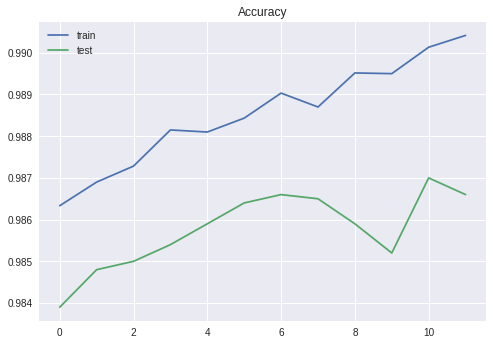

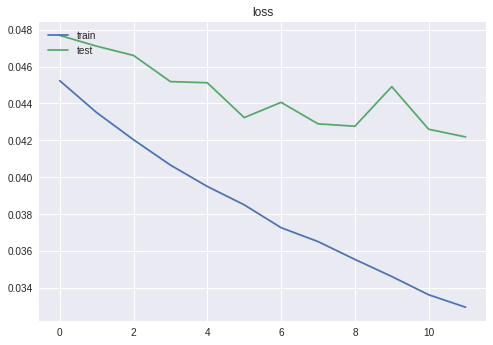

In [0]:
import matplotlib.pyplot as plt

plt.plot(hist1.history['acc'])
plt.plot(hist1.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

学習のステップ数をもっと長く取れば、もうすこし精度が良くなるかもしれません。
が、まあ良くなったとしても微妙な差でしょうか。

### ハイパーパラメータ

一次元の回帰の場合と同様、どのようなネットワーク、どのような学習パラメータなら最適な結果が得られるか、やってみないとわからないところが多々あります。

ネットワークの深さやフィルターの数などをいろいろ変えて、学習の精度や効率の変化を試してみましょう。

## Grad-CAM

CNNによる学習の結果は、単なる回帰などと違ってどのように情報が処理されているか、途中経過を見てもいささかわかりにくいという難点があります。

「深層学習はなんだか優秀そうだが、ブラックボックス化してしまって何故それが学習できているのか説明できない」という批判もしばしば聞かれます。

とはいえ近年では学習結果を分析するための手法もいろいろ提案されてきています。
ここでは学習結果を可視化するアプローチの一つとしてGradient-weighted Class Activation Mapping (Grad-CAM)を紹介します。

たとえば一つ目のテストサンプルの画像に対して、その画像のどの領域が分類に影響を及ぼしたか、逆算してみましょう。

とりあえずサンプルとして使う画像を、テストデータの1枚目とします（他のサンプルを見たいときは`aa`の値を適宜変えてください）。

In [0]:
sess = K.get_session()

aa = 12
x_tmp = x_tst[(aa-1):(aa),:]
y_tmp = y_test_org[aa-1]
pred_tmp = model1.predict(x_tmp)
y_pred = np.argmax(pred_tmp[0])

In [0]:
pred_tmp

array([[3.5918669e-07, 4.3439601e-12, 9.4185423e-11, 1.1659615e-11,
        1.1601323e-10, 5.1694720e-09, 9.9999869e-01, 1.1490661e-14,
        9.5507914e-07, 3.8875833e-13]], dtype=float32)

教師ラベルが`y_tmp`、分類された数字が`y_pred`です。
画像と合っているでしょうか。

org= 6 pred= 6


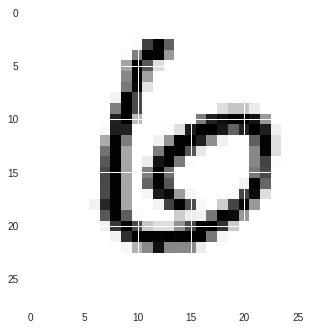

In [0]:
print("org=", y_tmp,"pred=",y_pred)
dumb = plt.imshow(x_tmp[0,:,:,0])

畳み込みレイヤーの出力を抽出して、その重みが答えの予測にどれだけ影響を受けていたかを調べます。

答えの出力ノードは10個ありますが、ここではとりあえず予測したラベルに対応する、一番出力の値の大きかった出力ノードに対する影響の大きさを調べることにします。

正しく判定できていたにしても、答えが間違ていたにしても、ニューラルネットワークが画像のどこを見て判断したか調べることができると期待されます。

`K.gradients()`で答えの出力ノードの値に対しての`last_conv_layer`の微分を計算します。
畳み込みレイヤーから出力された特徴マップの各ノードから答えの出力にあたえる影響の係数を得たことになります。

In [0]:
last_conv_layer = model1.layers[1]

out_tmp = model1.output[:, y_pred]

grad_tmp = K.gradients(out_tmp, last_conv_layer.output)[0]



今回のモデルでは`last_conv_layer`の出力は、一つ一つのマップが7x7サイズの出力ノードを持つ16枚の特徴マップになっています。

まず、いささか大雑把ですが、各マップごとに7x7の全部の係数の値を平均して、各マップごとの影響力を評価してみることにします。

In [0]:
pooled_grad = K.mean(grad_tmp, axis=(0, 1, 2))
get_grad = K.function([model1.input], [pooled_grad, last_conv_layer.output[0]])


In [0]:
pooled_grad_value,  last_conv_layer_output_value = get_grad([x_tmp])

<BarContainer object of 16 artists>

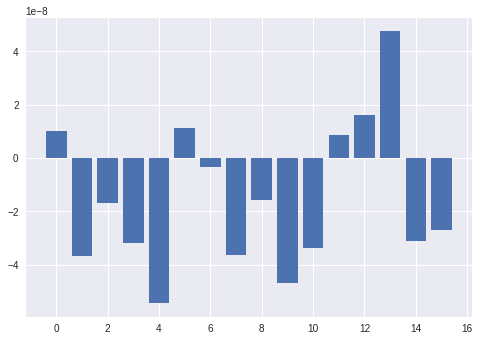

In [0]:
plt.bar(np.arange(16),pooled_grad_value)

ざっくばらんに言えば、この係数の絶対値が大きな特徴マップほど、最終的な数字の分類に大きく寄与したと言えそうです。

とりあえず一番影響の大きそうな特徴マップの出力をみてみましょう。

In [0]:
ii = np.argmax(np.abs(pooled_grad_value))
print(ii)

4


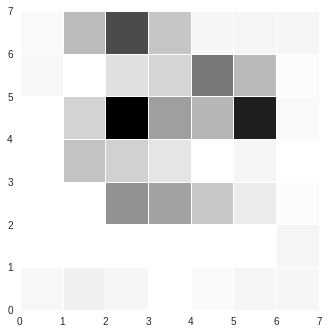

In [0]:
dumb = plt.imshow(last_conv_layer_output_value[:, :, ii],extent=[0,7,0,7])

黒いところほど値が大きいことを表しています。


...元画像の線分か曲線か、なにかの特徴に対応するマップのはずですが、どんな特徴かわかるでしょうか？

正直、6枚全部を見比べてもなかなか解釈は難しいと思われます。
それぞれの特徴マップが違ったパターンを抽出しているはずなのですが、ひとつひとつ個別に画像との対応を比較するのは大変です。


そこで、各マップに先ほど求めたマップごとの重みの平均をかけた上で、16枚の特徴マップを全部足し合わせてみましょう。

In [0]:
heatmap = last_conv_layer_output_value[:,:,0]*0

for ii in range(16):
        heatmap += last_conv_layer_output_value[:, :, ii]*pooled_grad_value[ii]

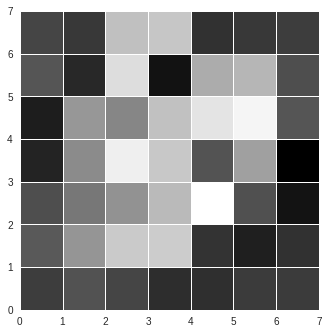

In [0]:
dumb = plt.imshow(heatmap,extent=[0,7,0,7])

なんとなく文字の印象が見えてきたでしょうか。

色をつけて、もと画像に重ね合わせてみます。

In [0]:

img_src = cv2.cvtColor(np.uint8(x_tmp[0,:,:,0]*255), cv2.COLOR_GRAY2RGB)

tmp0 = np.maximum(heatmap, 0)
tmp0 /= np.max(heatmap)
tmp0 = cv2.resize(tmp0, (ny, nx))
img_heatmap = cv2.applyColorMap(np.uint8(tmp0*255), cv2.COLORMAP_JET)
img_gcam = cv2.addWeighted(img_src, 0.6, img_heatmap, 0.4, 0)



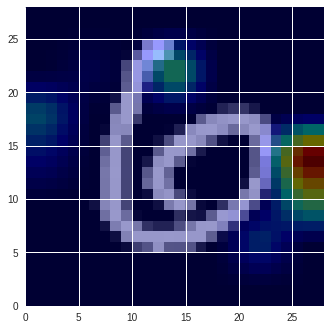

In [0]:
pix_tmp = cv2.cvtColor(img_gcam, cv2.COLOR_BGR2RGB)
dumb = plt.imshow(pix_tmp, extent=[0,28,0,28])

赤く表示された領域における画像の特徴が、色々な特徴を総合した結果この画像の判定にもっとも寄与している、ことになります。

それっぽい領域が赤く強調されているでしょうか。

### Guided back-prop

Grad-CAM では着目した特徴のある"領域"を強調しましたが、着目した特徴の形状を再構成しようとする方法としてはguided-back-propagationという手法が提案されています。

Grad-CAMと同じように入力画像をもとに再構成しますので、適当なサンプルを選びます。

画像を変えたい場合は`aa=12`の数字を好きな数に変えてください。

In [0]:
sess = K.get_session()
aa = 12
x_tmp = x_tst[(aa-1):(aa),:]
y_tmp = y_tst[(aa-1):(aa),]

各レイヤーごとに微分を逆算していくので、わかりやすいようにそれぞれのレイヤーオブジェクトをコピーしておきます。

In [0]:
model1.layers

In [0]:
L_input = model1.input
L_conv1 = model1.layers[0].output
L_conv2 = model1.layers[1].output
L_dense1 = model1.layers[3].output
L_dense2 = model1.layers[4].output


L_dense2の出力が10個のラベルに対応していますが、y_tmpを掛け算することで、正解のノード以外を0にします。

これらのノードは勾配が0になるので、正解のノードに寄与する特徴量が抽出できるようになります。

In [0]:
L_output = tf.multiply(L_dense2, y_tmp)


`L_output`に寄与する各レイヤーの影響の大きさを微分係数として求めるため、
傾きを計算する`gradients`関数を連鎖的に適用していきます。

前の層の微分を順番に掛け合わせてる「逆伝搬法」になっていますが、微分係数にReLU関数を適用することで、負に寄与する部分を無視している点が特徴となっています。


In [0]:
G_dense2 = tf.nn.relu(tf.gradients(L_output, L_dense2)[0])
G_dense1 = tf.nn.relu(tf.gradients(L_dense2, L_dense1, grad_ys = G_dense2)[0])
G_conv2 = tf.nn.relu(tf.gradients(L_dense1, L_conv2,  grad_ys = G_dense1)[0])
G_conv1 = tf.nn.relu(tf.gradients(L_conv2, L_conv1,  grad_ys = G_conv2)[0])
G_input = tf.nn.relu(tf.gradients(L_conv1, L_input,  grad_ys = G_conv1)[0])


得られた「顕著性」マップを元の画像と比べてみましょう。

（サリエンシー(saliency)は卓越性などと訳されることもありますが、ここでは"目を引く度合い"ぐらいの意味で、心理学や脳科学では画像や音の刺激が"どれぐらい注意を引きやすい"かの指標によく使われる名前です）

上が元画像、下が顕著性マップになります。

org= 6


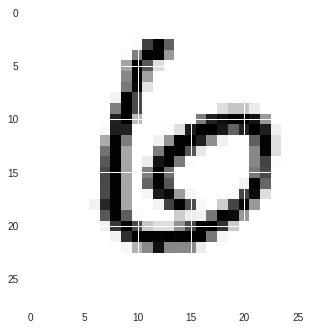

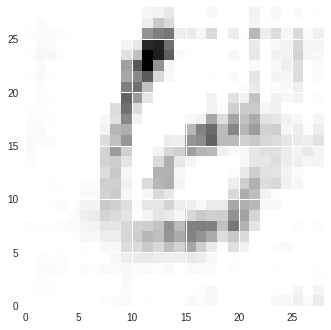

In [0]:
x_saliency = sess.run(G_input, feed_dict={L_input: x_tmp})[0]
print("org=", y_test_org[aa-1])
plt.figure(1)
dumb = plt.imshow(x_tmp[0,:,:,0])
plt.figure(2)
plt.imshow(x_saliency[:,:,0], extent=[0,28,0,28])
plt.show()

顕著性マップで現された画像パターンが、最終的に画像を分類したノードの出力に最も寄与していることを意味します。

文字の判別に適した特徴が含まれてているでしょうか？

数字の認識の課題の場合、あまり無視できる情報は含まれていないので元画像との差がわかりにくいかもしれませんが、一般の写真における物体認識のような課題だと、"背景"に対して被写体に着目している様子などがもっともらしく強調されるようです。

興味があれば入力画像をいろいろ変えて結果を比べてみてください。

[次のノートを開く](https://colab.research.google.com/github/naono-git/colaboratory/blob/master/note_05_hello_RDKit.ipynb)